In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import time

from collections import deque
import time
import random
from tqdm import tqdm
import os
from PIL import Image
import cv2
import pandas as pd


In [2]:
DISCOUNT = 0.99
REPLAY_MEMORY_SIZE = 50000  # How many last steps to keep for model training
MIN_REPLAY_MEMORY_SIZE = 300  # Minimum number of steps in a memory to start training
#MINIBATCH_SIZE = 64  # How many steps (samples) to use for training

#MINIBATCH_SIZE = 8  Duży skok
MINIBATCH_SIZE = 16


#UPDATE_TARGET_EVERY = 10  # Terminal states (end of episodes)


UPDATE_TARGET_EVERY = 2  # Terminal states (end of episodes)

MODEL_NAME = 'window48_profit'
MIN_REWARD = -200  # For model save
MEMORY_FRACTION = 0.20

# Environment settings
EPISODES = 1000

# Exploration settings
epsilon = 1  # not a constant, going to be decayed
EPSILON_DECAY = 0.99975
MIN_EPSILON = 0.001

#  Stats settings
AGGREGATE_STATS_EVERY = 10  # episodes
SHOW_PREVIEW = True

# For stats
ep_rewards = [-200]

# For more repetitive results
random.seed(1)

# Memory fraction, used mostly when trai8ning multiple agents
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=MEMORY_FRACTION)
#backend.set_session(tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)))

# Create models folder
if not os.path.isdir('models'):
    os.makedirs('models')




In [3]:
import gym
from gym import spaces
import numpy as np

class TimeSeriesEnv(gym.Env):
    def __init__(self, data, window_size=10):
        super(TimeSeriesEnv, self).__init__()
        self.data = data
        self.window_size = window_size
        self.current_step = window_size

        self.action_space = spaces.Discrete(3)  # 0 = hold, 1 = buy, 2 = sell
        self.observation_space = spaces.Box(
            low=0.0, high=1.0, shape=(window_size + 1,), dtype=np.float32
        )

        self.inventory = []
        self.total_profit = 0.0
        self.states_buy = []
        self.states_sell = []
        
        self.max_size = 100000
        
        self.min_val = np.min(data)
        self.max_val = np.max(data)

    def reset(self):
        self.current_step = self.window_size
        self.inventory = []
        self.total_profit = 0.0
        self.states_buy = []
        self.states_sell = []
        return self._get_observation()

    # def _get_observation(self):
    #     past = self.data[self.current_step - self.window_size:self.current_step]
    #     #future = self.data[self.current_step:self.current_step + self.future_size]
    #     #obs = np.concatenate([past, future])

    def _get_observation(self):
        past = self.data[self.current_step - self.window_size:self.current_step]
        self.min_val = np.min(past)
        self.max_val = np.max(past)

        norm_past = ((past - self.min_val) / (self.max_val - self.min_val + 1e-8)).astype(np.float32)
        inv = np.array([sum(self.inventory) / self.max_size], dtype=np.float32)  # znormalizowana liczba aktywów
        return np.concatenate((norm_past, inv))

    def step(self, action):
        done = False
        reward = 0.0
        price = self.data[self.current_step]
        #print(sum(self.inventory))
        if action == 1 and sum(self.inventory) <= self.max_size:  # Buy
            self.inventory.append(price)
            self.states_buy.append(self.current_step)
            # Brak nagrody za samo kupno

        elif action == 2 and len(self.inventory) > 0:  # Sell
            bought_price = self.inventory.pop(0)
            profit = price - bought_price
            reward = profit * profit#max(profit, 0)  # Możesz dać też samo `reward = profit` jeśli chcesz karać stratę
            self.total_profit += profit
            #reward = self.total_profit
            self.states_sell.append(self.current_step)

        # Hold (0) nic nie robi
        self.current_step += 1

        if self.current_step >= len(self.data):
            done = True
            if len(self.inventory) > 0:
                self.total_profit += np.sum(self.data[-1] - np.array(self.inventory, dtype=np.float32))


        return self._get_observation(), reward, done


In [4]:
from source.IB_connector import retrive_market_data
ticker = 'AAPL'
training_set_aapl = retrive_market_data([ticker], duration = "9 m", time_interval = "15 mins")
training_set = training_set_aapl[ticker]
training_set['Volume'] = training_set['Volume'].astype(float)
training_set['Date'] = pd.to_datetime(training_set['Date'].str.replace(' US/Eastern',''),format="%Y%m%d %H:%M:%S")
col_select = ['Open','High','Low','Close','Volume']
training_set = training_set[col_select]
training_set.dtypes
CLOSE_INDEX = col_select.index('Close')

ERROR -1 2104 Market data farm connection is OK:usfarm.nj
ERROR -1 2104 Market data farm connection is OK:cashfarm
ERROR -1 2104 Market data farm connection is OK:usfarm
ERROR -1 2106 HMDS data farm connection is OK:ushmds
ERROR -1 2158 Sec-def data farm connection is OK:secdefil


Found window with title: DUK343627 Interactive Brokers (Simulated Trading)


In [5]:
# import pandas as pd
#df = pd.read_csv('data/SP500.csv')
#data = df['Close'].values
# # # data

In [6]:
#len(data)  * 0.8

In [5]:

#add_trend = np.logspace(np.log(1.08), np.log(2), 500, base=np.exp(2))
#data = np.sin(np.linspace(0, 100, 500)).astype(np.float32)# + add_trend
data = training_set['Close'].values
data_split = int(len(data)  * 0.8)
train_data = data[:data_split]
valid_data = data[data_split:]

WINDOW_SIZE = 96
env = TimeSeriesEnv(train_data, window_size=WINDOW_SIZE)
valid_env = TimeSeriesEnv(valid_data,window_size=WINDOW_SIZE)

In [6]:
done = 0
env.reset()
count_steps = 0
while not done:
    new_state, reward, done = env.step(1)
    count_steps +=1

count_steps

3693

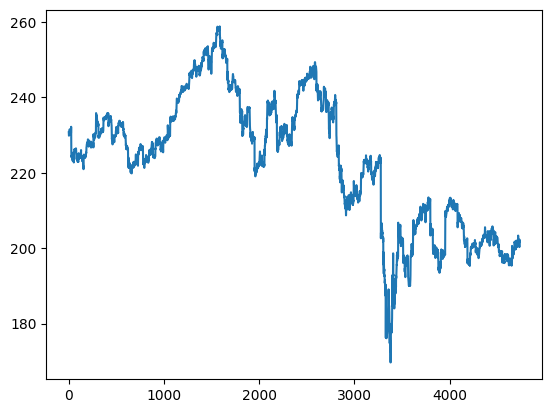

In [7]:
import matplotlib.pyplot as plt

plt.plot(data)

In [8]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Prosta sieć neuronowa w PyTorchu
# class DQN(nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super(DQN, self).__init__()
#         self.fc1 = nn.Linear(input_dim, 32)
#         self.fc2 = nn.Linear(32, 16)
#         self.fc3 = nn.Linear(16, 8)
#         self.output = nn.Linear(8, output_dim)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = torch.relu(self.fc3(x))
#         return self.output(x)

#Window - 48
# class DQN(nn.Module):
# 	def __init__(self, input_dim, output_dim):
# 		super(DQN, self).__init__()
# 		self.out_steps = output_dim

# 		self.lstm = nn.LSTM(input_size=input_dim, hidden_size=48, batch_first=True)
# 		self.dropout = nn.Dropout(p=0.4)

# 		self.fc = nn.Linear(48, 32)
# 		self.fc2 = nn.Linear(32, 24)
# 		self.fc3 = nn.Linear(24, 16)
# 		self.fc4 = nn.Linear(16, output_dim)

# 	def forward(self, x):
# 		#_, (h_n, _) = self.lstm(x)  # h_n: [1, batch, lstm_units]
# 		h_n, _ = self.lstm(x)  # h_n: [1, batch, lstm_units]

# 		h_n = h_n.squeeze(0)        # [batch, lstm_units]
# 		#h_n = self.dropout(h_n)        # [batch, lstm_units]

# 		x = torch.relu(self.fc(h_n))            # [batch, out_steps * num_features]
# 		x = torch.relu(self.fc2(x))            # [batch, out_steps * num_features]
# 		x = torch.relu(self.fc3(x))            # [batch, out_steps * num_features]

  
# 		#x = self.dropout(x)            # [batch, out_steps * num_features]
  
# 		x = self.fc4(x)		# [out_steps * num_features, close_price]
# 		#x = self.dropout(x)            # [batch, out_steps * num_features]

# 		x = x.view(-1, self.out_steps, 1)
# 		return x

#window 96
# class DQN(nn.Module):
# 	def __init__(self, input_dim, output_dim):
# 		super(DQN, self).__init__()
# 		self.out_steps = output_dim

# 		self.lstm = nn.LSTM(input_size=input_dim, hidden_size=64, batch_first=True)
# 		self.dropout = nn.Dropout(p=0.4)

# 		self.fc = nn.Linear(64, 48)
# 		self.fc2 = nn.Linear(48, 24)
# 		self.fc3 = nn.Linear(24, 16)
# 		self.fc4 = nn.Linear(16, output_dim)

# 	def forward(self, x):
# 		#_, (h_n, _) = self.lstm(x)  # h_n: [1, batch, lstm_units]
# 		h_n, _ = self.lstm(x) 
# 		h_n = h_n.squeeze(0)        
# 		x = torch.relu(self.fc(h_n))            
# 		x = self.dropout(x)
# 		x = torch.relu(self.fc2(x))
# 		x = self.dropout(x)
# 		x = torch.relu(self.fc3(x))
# 		x = self.dropout(x)
# 		x = self.fc4(x)
# 		x = x.view(-1, self.out_steps, 1)
# 		return x


class DQN(nn.Module):
	def __init__(self, input_dim, output_dim):
		super(DQN, self).__init__()
		self.out_steps = output_dim

		self.lstm = nn.LSTM(input_size=input_dim, hidden_size=8, batch_first=True)
		self.dropout = nn.Dropout(p=0.2)

		#elf.fc = nn.Linear(16, 48)prosolukasz  Ferrari0234!INTERACTIVE
  
		#self.fc2 = nn.Linear(48, output_dim)
		#self.fc3 = nn.Linear(24, 16)
		self.fc4 = nn.Linear(8, output_dim)

	def forward(self, x):
		#_, (h_n, _) = self.lstm(x)  # h_n: [1, batch, lstm_units]
		h_n, _ = self.lstm(x) 
		h_n = h_n.squeeze(0)        
		#x = torch.relu(self.fc(h_n))            
		#x = self.dropout(x)
		#x = torch.relu(self.fc2(x))
		#x = self.dropout(x)
		#x = torch.relu(self.fc3(x))
		#x = self.dropout(x)
		x = self.fc4(h_n)
		x = x.view(-1, self.out_steps, 1)
		return x





class DQNAgent:
    def __init__(self):
        self.model = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
        self.target_model = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.target_model.eval()

        #self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0001, weight_decay=1e-2)
        self.loss_fn = nn.MSELoss()

        self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)
        self.target_update_counter = 0

    def update_replay_memory(self, transition):
        self.replay_memory.append(transition)

    def train(self, terminal_state):
        if len(self.replay_memory) < MIN_REPLAY_MEMORY_SIZE:
            return

        minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)

        # Rozpakowanie danych
        states, actions, rewards, next_states, dones = zip(*minibatch)

        states_v = torch.from_numpy(np.array(states)).float().to(device)
        next_states_v = torch.from_numpy(np.array(next_states)).float().to(device)
        actions_v = torch.tensor(actions, dtype=torch.int64, device=device)
        rewards_v = torch.tensor(rewards, dtype=torch.float32, device=device)
        dones_v = torch.tensor(dones, dtype=torch.bool, device=device)        
        
        with torch.no_grad():
            target_qs = self.target_model(next_states_v).flatten(start_dim=1)
            max_future_qs = torch.max(target_qs, dim=1)[0]
            new_qs = rewards_v + (~dones_v * DISCOUNT * max_future_qs)

        #print(states_v.shape)
        current_qs = self.model(states_v).flatten(start_dim=1)
        #print(current_qs.flatten(start_dim=1).shape)
        #print(actions_v.shape)
        predicted_qs = current_qs.gather(1, actions_v.unsqueeze(1)).squeeze()

        loss = self.loss_fn(predicted_qs, new_qs)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if terminal_state:
            self.target_update_counter += 1

        if self.target_update_counter > UPDATE_TARGET_EVERY:
            self.target_model.load_state_dict(self.model.state_dict())
            self.target_update_counter = 0

    def get_qs(self, state):
        #state = np.array(state) / 255.0
        state_v = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            qs = self.model(state_v)
            #qs = self.target_model(state_v)
        return qs #.cpu().numpy()[0]


def evaluate_steps(env, model, device="cuda:0"):
    state = env.reset()
    total_reward = 0
    done = False
    steps = 0
    action = 0
    while not done:
        # konwersja stanu na tensora
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

        with torch.no_grad():
            q_values = model(state_tensor)
            action = torch.argmax(q_values).item()

        state, reward, done = env.step(action)
        total_reward += reward
        steps += 1
        #print(f"Krok: {steps}, Akcja: {action}, Nagroda: {reward:.2f}, Łączny zysk: {env.total_profit:.2f}")

    #print(state_tensor)
    return total_reward

In [11]:
from copy import deepcopy
agent = DQNAgent()
reward_all = []
evaluate_revards = []


In [15]:
import math

model = DQN(96,3)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

VCD_UPPER = int(2 * trainable_params * math.log(trainable_params))

#VCD_LOWER = 2 * 
print(VCD_UPPER, "minimalna liczba próbek - ",VCD_UPPER*10 )

55641 minimalna liczba próbek -  556410


In [ ]:
import multiprocessing
from torch.distributions import Categorical


#EPSILON_DECAY = 0.998
EPSILON_DECAY = 0.99

def train_episode(episode, epsilon):
    # Update tensorboard step every episode
    #agent.tensorboard.step = episode

    # Restarting episode - reset episode reward and step number
    episode_reward = 0
    step = 1

    # Reset environment and get initial state
    current_state = env.reset()

    # Reset flag and start iterating until episode ends
    done = False
    while not done:

        # This part stays mostly the same, the change is to query a model for Q values
        if np.random.random() > epsilon:
            # Get action from Q table
            #action = np.argmax(agent.get_qs(current_state))
            probs = torch.softmax(agent.get_qs(current_state).squeeze(), dim=0)
            dist = Categorical(probs)
            action = dist.sample().item()  # zamiast .numpy()[0]
            #print(action)
        else:
            # Get random action
            action = np.random.randint(0, env.action_space.n)

        new_state, reward, done = env.step(action)

        # Transform new continous state to new discrete state and count reward
        episode_reward += reward


        # Every step we update replay memory and train main network
        agent.update_replay_memory((current_state, action, reward, new_state, done))
        
        #0.5 spoko dla 100 batch, ciągle losowao jak idiz esie dalej(bez dropout), batch size 8, EPSILON_DECAY = 0.99 
        
        #0.5 spoko dla 100 batch, ciągle losowao jak idiz esie dalej(z dropout), batch size 8, EPSILON_DECAY = 0.99 - lepiej, większy zysk
        
        #0.7 TOP dla 100 batch, ciągle losowao jak idiz esie dalej(z dropout), batch size 8, EPSILON_DECAY = 0.99 - lepiej, większy zysk
        if np.random.random() >= .7:
            agent.train(done)

        current_state = new_state
        step += 1
 
    # Append episode reward to a list and log stats (every given number of episodes)
    ep_rewards.append(episode_reward)
    if SHOW_PREVIEW and not episode % AGGREGATE_STATS_EVERY:
            print(f"Episode: {episode} Total Reward: {env.total_profit} Epsilon: {epsilon:.2f}")

    
    if not episode % AGGREGATE_STATS_EVERY or episode == 1:
        average_reward = sum(ep_rewards[-AGGREGATE_STATS_EVERY:])/len(ep_rewards[-AGGREGATE_STATS_EVERY:])
        min_reward = min(ep_rewards[-AGGREGATE_STATS_EVERY:])
        max_reward = max(ep_rewards[-AGGREGATE_STATS_EVERY:])
        #agent.tensorboard.update_stats(reward_avg=average_reward, reward_min=min_reward, reward_max=max_reward, epsilon=epsilon)

        # Save model, but only when min reward is greater or equal a set value
        #if min_reward >= MIN_REWARD:
        #    agent.model.save(f'models/{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}.h5')


    return episode_reward

#super dla 200, batch64
EPISODES = 100
# Iterate over episodes
max_agent = DQNAgent()
max_reward = 0
evaluate_every = 1
for episode in tqdm(range(1, EPISODES + 1), ascii=True, unit='episodes'):
    reward = train_episode(episode,epsilon)
    
    
    if epsilon > MIN_EPSILON:
        epsilon *= EPSILON_DECAY
        epsilon = max(MIN_EPSILON, epsilon)

    
    reward_all.append(reward)
    #if episode % evaluate_every:
    valid_env.reset()
    reward_valid_dataset = evaluate_steps(valid_env, agent.target_model)
    evaluate_revards.append(reward_valid_dataset)
    
    if reward_valid_dataset > max_reward and episode > 10:
        max_reward = reward_valid_dataset
        #print(max_reward)
        max_agent = deepcopy(agent)
    
    #print(reward_valid_dataset)
    if max_reward > 0 and episode > 10 and reward_valid_dataset / max_reward <= .7:
        agent = deepcopy(max_agent)

    
#bierz Q z target modelu
    

#przed opt - 18 min

  0%|          | 0/100 [00:00<?, ?episodes/s]

0
0
0
0
0
0
222.92
446.22
446.22
223.3
223.3
0
0
224.51
448.83
672.7
448.19
672.27
897.01
897.01
672.69
448.82000000000005
673.1700000000001
897.6400000000001
673.5600000000001
673.5600000000001
673.5600000000001
448.82
673.12
673.12
897.86
1122.43
1122.43
1122.43
898.0799999999999
898.0799999999999
1122.35
1346.6399999999999
1122.17
897.87
1122.39
1122.39
1346.68
1570.73
1794.83
1794.83
1794.83
1570.09
1793.27
1568.7
1791.73
2014.72
1790.45
1566.16
1341.64
1341.64
1117.35
893.3
893.3
1114.73
890.6300000000001
667.45
891.73
668.7
892.8100000000001
892.8100000000001
669.82
669.82
448.39
448.39
224.11
448.36
224.25
224.25
224.25
224.25
448.2
448.2
672.37
672.37
896.51
672.26
896.81
896.81
672.8599999999999
897.4799999999999
673.31
673.31
673.31
673.31
449.17
449.17
449.17
224.62
0
0
0
0
227.91
0
0
0
228.06
0
0
0
0
0
0
0
228.27
228.27
228.27
228.27
228.27
0
0
227.35
0
227.35
0
0
227.86
455.9
683.81
683.81
455.95
227.91
227.91
227.91
0
0
0
227.53
227.53
455.12
227.59
455.86
455.86
682.53
6

  1%|1         | 1/100 [00:06<11:08,  6.75s/episodes]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
223.08
223.08
223.08
446.0
669.3
894.16
671.08
448.16
224.86
448.58000000000004
673.09
673.09
896.96
896.96
896.96
1121.7
1121.7
1345.8600000000001
1121.0
1121.0
1345.47
1345.47
1345.47
1345.47
1121.75
1121.75
1121.75
897.24
897.24
673.37
898.94
1124.95
1124.95
1124.95
900.21
900.21
676.05
900.5699999999999
1124.6999999999998
1124.6999999999998
1348.7499999999998
1348.7499999999998
1124.28
1347.75
1122.18
1122.18
1122.18
896.1700000000001
896.1700000000001
896.1700000000001
1119.0800000000002
1119.0800000000002
894.56
1116.11
1337.9099999999999
1337.9099999999999
1113.78
889.73
666.26
666.26
443.35
667.46
445.91
224.11
448.21000000000

  2%|2         | 2/100 [00:11<09:00,  5.52s/episodes]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
222.92
0
0
225.18
449.58000000000004
449.58000000000004
224.4
448.90999999999997
224.51
448.38
448.38
448.38
673.12
448.61
448.61
448.61
672.96
897.4300000000001
897.4300000000001
1121.97
898.1
673.36
449.01
673.45
898.19
673.72
449.18
449.18
449.18
224.74
449.01
224.27
224.27
448.89
673.41
449.14
224.52
0
0
223.78
223.78
0
0
0
223.03
0
223.08
223.08
0
0
221.55
0
221.78
221.78
221.78
221.78
446.06
224.28
224.28
449.1
673.35
449.07
449.07
673.69
673.69
448.87
672.9
672.9
672.9
672.9
672.9
672.9
672.9
448.65
224.03
448.21000000000004
672.76
897.27
897.27
673.24
898.23
674.05
449.5
449.5
675.8
675.8
675.8
675.8
675.8


  3%|3         | 3/100 [00:16<08:18,  5.14s/episodes]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
223.27
446.33000000000004
223.06
223.06
0
0
0
0
225.18
0
224.1
0
0
0
0
0
0
0
224.07
224.07
0
0
224.47
224.47
0
0
0
224.3
448.74
448.74
448.74
224.44
0
0
0
224.27
448.56
224.29
224.29
224.29
224.29
224.29
0
224.1
0
0
0
0
0
0
0
0
222.91
222.91
0
0
0
0
0
0
223.42
223.42
447.32
447.32
223.9
223.9
448.0
448.0
224.1
224.1
0
224.03
0
0
0
0
0
224.17
0
224.14
224.14
448.69
448.69
673.17
673.17
449.03
449.03
674.39
449.84000000000003
225.36
0
0
0
0
227.66
0
227.52
455.43
227.91
0
227.99
456.05
456.05
456.05
456.05
456.05
684.76
456.77
228.71
0
0
0
226.95
0
227.14
227.14
0
227.03
0
0
227.56
0
0
227.91
227.91
227.91


  4%|4         | 4/100 [00:20<08:02,  5.03s/episodes]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
223.08
223.08
223.08
0
0
0
225.18
449.58000000000004
449.58000000000004
449.58000000000004
449.58000000000004
449.58000000000004
673.45
448.27
223.87
448.61
448.61
448.61
224.74
224.74
0
0
224.54
0
0
224.3
224.3
449.04
673.61
449.31
449.31
449.31
224.57
0
224.29
0
0
0
224.13
448.41999999999996
224.29
224.29
0
223.47
223.47
0
0
223.03
446.02
446.02
668.93
668.93
891.2099999999999
891.2099999999999
1113.01
889.98
1111.41
1111.41
1111.41
888.4200000000001
1112.3200000000002
889.41
1114.23
891.95
1116.05
1340.59
1340.59
1118.7900000000002
1343.0400000000002
1121.6100000000001
1345.5300000000002
1345.5300000000002
1345.5300000000002
1121.6299999999999
896.81
1120.98
1345.17
1121.07
1345.2

  5%|5         | 5/100 [00:25<07:51,  4.96s/episodes]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
222.83
0
0
0
225.18
449.58000000000004
224.4
224.4
0
0
223.87
0
0
224.74
224.74
224.74
0
0
0
0
224.54
448.63
448.63
448.63
224.09
224.09
224.09
0
0
0
0
0
0
0
0
224.52
0
0
224.05
224.05
224.05
224.05
0
223.18
223.18
446.21000000000004
669.2
892.2800000000001
892.2800000000001
669.1
446.07000000000005
667.6200000000001
444.63
221.55
221.55
0
0
0
0
0
0
224.25
448.35
224.1
224.1
224.1
448.35
448.35
448.35
448.35
672.26
448.15999999999997
223.91
0
224.19
448.33
448.33
224.14
448.65
448.65
673.27
898.26
1123.22
1348.58
1124.44
1124.44
1351.2
1126.69
1354.06
1581.4499999999998
1356.83
1131.8400000000001
1131.8400000000001
906.88
1134.93
1362.78
1362.78
1590.84
1365.4799999999998
1365.4799999999998
1365.4799999999998
1138.72
1138.72
1138.72
1366.8400000000001
1366.8400000000001
1139.4699999999998


  6%|6         | 6/100 [00:30<07:43,  4.94s/episodes]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
223.27
223.27
223.27
446.12
446.12
446.12
222.85
447.71000000000004
447.71000000000004
224.86
448.96000000000004
224.1
448.61
224.51
0
223.77
0
224.74
448.81
448.81
673.41
897.76
897.76
673.02
673.02
448.95
224.35
224.35
448.78999999999996
448.78999999999996
673.3599999999999
898.6599999999999
1124.2299999999998
1124.2299999999998
1348.2799999999997
1123.9299999999998
1123.9299999999998
899.49
899.49
1124.01
1348.1399999999999
1348.1399999999999
1572.1899999999998
1796.2899999999997
1571.72
1795.19
1795.19
2018.3700000000001
2241.86
2016.56
2239.55
2239.55
2239.55
2013.98
2013.98
2235.53
2011.48
2011.48
2232.91
2453.85
2453.85
2453.85
2453.85
2453.85
2678.67
2678.67
2902.77
2678.25
2902.87
2678.74
2678.74
2454.69
2454.69
245

  7%|7         | 7/100 [00:35<07:46,  5.01s/episodes]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
223.3
448.16
673.34
897.74
1121.84
898.5400000000001
1123.0500000000002
1123.0500000000002
898.19
1121.96
1346.04
1346.04
1570.11
1344.9299999999998
1120.53
1120.53
1345.0
1120.9
896.3900000000001
896.3900000000001
672.62
896.9200000000001
672.8399999999999
897.5799999999999
897.5799999999999
673.51
673.51
899.52
1123.57
1123.57
899.0999999999999
674.8
450.06
450.06
450.06
450.06
450.06
450.06
224.05
447.52
223.47
0
0
223.03
223.03
223.03
445.94
668.91
445.8

  8%|8         | 8/100 [00:40<07:43,  5.03s/episodes]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
223.08
0
0
0
223.3
448.16
224.86
449.26
224.4
0
0
224.32
0
0
224.08
448.82000000000005
224.74
0
224.6
448.95
448.95
448.95
224.35
224.35
0
224.3
224.3
0
224.57
224.57
0
226.01
226.01
450.28
450.28
224.27
0
224.52
0
224.29
224.29
0
0
0
0
0
223.49
0
0
0
0
0
0
0
0
221.78
0
0
0
0
0
0
0
0
0
0
0
0
224.25
448.28
672.1999999999999
672.1999999999999
447.95
223.92
0
224.17
0
0
224.18
448.73
448.73
673.21
449.03
449.03
224.48
0

  9%|9         | 9/100 [00:45<07:36,  5.02s/episodes]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
222.85
0
222.92
0
0
225.18
225.18
225.18
448.9
223.72
223.72
223.72
447.49
447.49
223.77
0
224.16
224.16
224.16
0
0
224.54
448.63
672.65
448.11
672.55
672.55
448.46000000000004
224.44
450.01
450.01
225.57
0
0
0
0
224.52
224.52
0
0
0
223.78
0
0
223.18
0
0
0
0
0
222.97
222.97
0
0
0
0
0
0
0
223.9
448.01
672.8299999999999
897.0799999999999
1121.1799999999998
1345.7199999999998
1345.7199999999998
1570.2799999999997
1570.2799999999997
1570.2799999999997
1346.38
1122.27
1122.27
1346.22
1121.4
1121.4
897.1500000000001
673.05
673.05
673.05
897.56
897.56
1122.1799999999998
1347.1699999999998
1122.63
1347.9900000000002
1347.9900000000002
1347.9900000000002
1347.9900000000002
1574.8400000000001
1350.2799999999997
112

 10%|#         | 10/100 [00:50<07:30,  5.01s/episodes]

0
223.27
223.27
223.27
223.27
0
0
0
224.86
224.86
449.26
449.26
672.98
448.12
448.12
671.99
671.99
447.59000000000003
447.59000000000003
223.87
448.03
224.16
0
224.47
448.78
448.78
448.78
672.8
897.0999999999999
897.0999999999999
672.6300000000001
897.2
672.8900000000001
672.8900000000001
448.87
224.57
0
0
0
224.62
449.14
224.52
448.81
448.81
224.29
224.29
0
0
223.18
446.67
669.7
446.52
223.03
0
222.97
445.25
222.28
444.08000000000004
665.86
887.29
665.01
665.01
889.29
1113.19
1337.3000000000002
1115.5
893.72
672.29
672.29
896.91
1121.47
1121.47
897.19
897.19
673.29
673.29
449.18
673.14
897.31
672.6899999999999
448.13
224.17
448.72
673.23
673.23
449.06
224.51
224.51
224.51
0
0
226.76
0
0
0
0
227.62
0
227.91
227.91
227.91
455.9
683.96
456.05
456.05
456.05
228.06
456.77
456.77
228.71
0
0
0
0
0
227.14
454.6
227.46
0
0
0
0
227.86
227.86
0
0
0
0
227.7
455.7
228.0
0
227.52
455.05
455.05
455.05
683.1
455.58000000000004
683.8100000000001
683.8100000000001
456.28
228.23
0
0
0
227.42
454.6
227.1

 11%|#1        | 11/100 [00:56<07:29,  5.05s/episodes]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
223.08
0
0
0
0
0
225.18
225.18
449.28
673.0
897.51
672.3299999999999
896.1999999999999
672.1
672.1
448.38
223.87
0
0
0
0
0
224.54
0
0
0
0
224.74
0
0
0
0
0
0
0
0
224.62
449.14
449.14
224.52
0
0
0
223.47
0
0
0
0
0
0
0
0
0
0
0
221.78
443.21000000000004
443.21000000000004
443.21000000000004
221.43
445.33000000000004
669.44
669.44
669.44
669.44
669.44
448.01
672.5699999999999
896.8199999999999
672.9200000000001
448.81
672.73
896.64
1120.59
896.03
671.78
671.78
447.86
447.86
447.86
672.37
672.37
448.46
673.45
449.5
224.99
224.99
224.99
0
0
0
0
0
0
0
0
0
227.85
227.85
227.85
455.72
455.72
227.87
227.87
227.87
0
228.12
228.12
456.78999999999996
456.78999999999996
456.78999999999996
228.67
228.67
228.67
0
227.03
0
0
227.56
455.42
455.42
683.33
455.77
227.91
455.45
227.54
227.54
227.54
455.21
455.21
455.21
455.21
227.67
455.72
228.05
0
226.67
226.67
454.42999999999995
227.76
0
0
0
0
0
0
227.08
454.11


 12%|#2        | 12/100 [01:01<07:24,  5.06s/episodes]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
223.06
446.14
223.08
445.91
668.83
445.75
670.61
447.78
447.78
224.86
0
0
0
0
0
0
224.74
0
224.16
0
0
0
0
0
0
0
0
0
224.74
0
0
0
226.01
450.06
450.06
450.06
224.05
448.67
224.62
0
224.29
0
224.1
224.1
224.1
0
0
0
0
0
223.08
445.99
445.99
445.99
445.99
222.91
444.69
221.78
0
0
0
223.9
223.9
0
0
224.1
224.1
0
224.56
0
0
0
223.92
447.83
671.78
447.86
223.95
223.95
223.95
0
0
224.51
448.99
673.61
449.1
449.1
449.1
224.62
0
0
226.85
0
227.39
0
227.62
227.62
0
228.05
0
0
0
0
0
0
0
0
228.5
0
0
228.67
228.67
228.67
0
0
0
0
0
0
0
227.56
455.42
683.46
911.37
1138.92
1366.56
1594.1
1366.54
1366.54
1138.68
1366.3500000000001
1138.31
1138.31
910.4
682.8499999999999
682.8499999999999
682.8499999999999
455.21
455.21
227.67
227.67
227.67
227.67
0
227.42
454.6
454.6
227.18
0
0
226.85
226.85
0
0
226.92
453.95
227.03
0
227.54
227.54
227.54
0
0
0
230.24
230.24
459.69
229.45
459.28999999999996
229.84
0
0
0
0
229.34
458.78
229.44


 13%|#3        | 13/100 [01:06<07:31,  5.19s/episodes]

0
223.27
0
0
0
0
0
0
0
0
224.4
0
0
224.51
448.83
224.32
0
0
224.74
0
0
0
224.35
448.82
224.47
224.47
448.56
448.56
672.86
448.39
673.13
449.04
674.34
674.34
674.34
674.34
450.04
225.3
0
0
0
224.13
448.41999999999996
672.47
448.34000000000003
224.05
447.52
670.9
894.0799999999999
894.0799999999999
1117.11
893.06
669.59
892.5
669.12
445.94
667.49
889.29
666.26
887.69
1108.63
1332.0500000000002
1332.0500000000002
1332.0500000000002
1109.14
1109.14
1109.14
1333.24
1111.69
889.89
889.89
1114.1399999999999
1114.1399999999999
1114.1399999999999
1114.1399999999999
892.71
892.71
671.77
895.9399999999999
1120.1299999999999
896.71
896.71
1121.26
897.1599999999999
1121.6399999999999
897.3900000000001
897.3900000000001
897.3900000000001
673.22
898.49
1124.79
900.5999999999999
1127.4499999999998
902.9
678.4200000000001
906.08
680.81
454.51
227.66
227.66
455.51
227.85
455.90999999999997
455.90999999999997
228.06
455.99
455.99
684.7
456.64
684.76
913.03
1141.7
913.77
913.77
1141.4099999999999
912.6999

 14%|#4        | 14/100 [01:12<07:32,  5.26s/episodes]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
223.06
0
0
0
222.92
446.22
223.3
0
0
224.1
0
224.51
0
0
0
224.08
0
0
0
224.6
0
0
224.31
0
224.09
224.09
0
0
0
0
0
0
0
0
0
0
0
224.62
224.62
0
0
0
0
0
223.47
0
0
223.49
446.52
669.51
669.51
446.02
222.99
0
0
0
0
0
0
0
0
0
224.11
448.93
224.82
0
0
0
0
0
224.03
0
0
0
223.95
0
224.17
224.17
224.17
224.17
0
0
0
0
0
0
0
225.27
0
0
0
0
0
227.66
0
0
0
0
0
0
0
0
0
0
228.84
0
0
228.12
228.12
456.78999999999996
228.67
0
0
0
0
0
0
227.35
0
0
0
0
0
227.55
227.55
455.09000000000003
227.54
455.53999999999996
683.3599999999999
455.82
227.82
455.35
227.53
0
0
0
0
0
0
227.76
455.72

 15%|#5        | 15/100 [01:17<07:33,  5.34s/episodes]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
223.06
223.06
223.06
0
0
0
224.86
0
224.4
0
0
0
0
0
0
224.08
448.82000000000005
224.74
0
224.6
0
0
0
0
224.09
0
224.3
0
224.74
224.74
450.04
675.61
901.62
1125.67
900.9300000000001
675.63
675.63
900.25
674.6800000000001
898.8100000000001
1123.1000000000001
897.0899999999999
673.04
673.04
448.41999999999996
224.29
0
0
0
0
0
0
0
0
221.55
443.35
221.8
0
0
0
224.28
224.28
448.39
224.11
448.36
224.25
224.25
0
0
224.25
224.25
448.16999999999996
448.16999999999996
448.16999999999996
223.92
0
224.17
0
0
224.18
448.73
224.55
449.03
673.65
449.1
674.0600000000001
899.4200000000001
674.94
450.32000000000005
225.36
225.36
0
0
0
0
0
227.91
227.91
0
0
228.06
0
0
0
0
0
228.5
456.62
228.12
456.7899999

 16%|#6        | 16/100 [01:23<07:46,  5.55s/episodes]

0
0
223.06
0
0
222.83
0
223.3
0
0
224.4
448.5
224.1
0
0
0
0
0
0
0
224.16
224.16
0
0
0
0
0
224.02
0
0
0
224.57
0
225.57
451.58
451.58
675.85
675.85
675.85
450.28
674.8
448.79
448.79
224.52
224.52
224.52
0
223.38
223.38
446.87
223.49
223.49
0
222.91
222.91
0
221.55
0
0
0
0
0
224.28
0
0
224.82
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
224.51
0
0
0
0
0
0
226.3
453.06
453.06
453.06
226.76
226.76
454.38
454.38
454.38
682.4300000000001
455.67
455.67
683.73
456.11
683.81
683.81
912.65
912.65
912.65
684.6
912.87
1141.54
913.4799999999999
1140.4299999999998
912.73
1139.87
1139.87
911.03
682.76
454.09
454.09
681.65
454.7
454.7
454.7
227.56
0
227.54
227.54
0
0
0
0
0
0
227.59
0
0
0
226.67
226.67
0
227.96
0
0
0
227.18
0
0
0
0
0
0
0
0
0
0
0
0
227.54
0
0
0
0
0
0
0
0
0
0
0
0
0
228.96
228.96
0
0
229.76
0
0
229.62
459.17
229.55
459.08000000000004
688.73
918.88
918.88
689.33
689.33
920.11
690.58
460.93
460.93
460.93
230.78
465.57
234.79
234.79
469.4
704.63
469.84000000000003
704.53
938.47
1172.43
1406.09000000000

 17%|#7        | 17/100 [01:30<08:16,  5.98s/episodes]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
223.08
223.08
223.08
0
0
224.86
224.86
0
0
0
0
224.32
224.32
0
0
0
224.07
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
224.29
224.29
224.29
0
0
224.29
0
0
223.78
223.78
223.78
0
0
223.03
0
0
0
0
0
0
221.8
443.58000000000004
443.58000000000004
221.78
0
0
223.9
223.9
0
0
0
0
224.62
0
0
0
0
0
0
223.95
223.95
448.12
448.12
672.26
672.26
448.30999999999995
224.14
0
0
224.99
449.95000000000005
224.96
224.96
451.26
226.3
453.15
453.15
226.85
0
0
0
0
228.05
0
0
0
0
0
0
0
0
0
228.12
0
0
0
226.95
0
0
227.46
227.46
227.46
227.46
227.46
0
0
0
227.91
227.91
455.54999999999995
455.54999999999995
683.25
455.34
455.34
455.34
682.86
910.39
910.39
1137.

 18%|#8        | 18/100 [01:36<08:20,  6.10s/episodes]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
223.08
445.93
445.93
222.85
222.85
447.71000000000004
672.8900000000001
450.04
450.04
225.18
0
0
223.87
223.87
0
224.74
0
0
0
224.35
0
224.31
224.31
448.4
672.42
448.11
224.02
0
0
0
0
226.01
450.06
450.06
674.35
898.88
898.88
1123.4
897.39
1121.68
1345.73
1121.68
897.3900000000001
897.3900000000001
672.86
448.34000000000003
224.05
0
0
223.08
0
222.97
445.25
445.25
222.28
444.06
665.49
886.4300000000001
664.1500000000001
664.1500000000001


 19%|#9        | 19/100 [01:43<08:22,  6.21s/episodes]

0
0
0
0
222.85
0
222.92
446.22
223.3
223.3
0
224.1
447.82
223.72
223.72
0
223.77
447.85
224.08
224.08
224.08
224.08
0
0
224.31
0
0
224.02
0
0
0
0
0
225.57
225.57
449.62
449.62
449.62
674.15
674.15
898.67
898.67
1122.96
897.39
1121.49
897.44
897.44
1120.8200000000002
896.29
671.77
894.8
670.51
446.40999999999997
223.03
0
222.28
0
0
0
0
0
0
0
223.9
223.9
448.72
224.82
448.91999999999996
224.1
0
0
0
0
0
223.92
0
223.95
447.90999999999997
223.96
448.15
448.15
448.15
672.7
448.74
224.55
0
0
224.96
0
0
226.3
226.3
0
0
0
0
0
0
0
0
0
0
0
0
227.7
455.63
455.63
684.34
912.84
912.84
912.84
685.14
913.8399999999999
1140.79
1368.4299999999998
1595.5699999999997
1367.6399999999999
1138.9299999999998
910.43
681.73
454.78
682.3399999999999
454.7
227.56
455.47
227.91
0
227.54
455.24
227.7
455.52
683.1899999999999
910.7099999999999
683.01
910.7
910.7
1138.75
1367.02
1595.25
1821.92
1594.1000000000001
1594.1000000000001
1594.1000000000001
1366.43
1138.91
911.22
1138.4
1365.52
1137.4699999999998
909.19999

 20%|##        | 20/100 [01:49<08:23,  6.30s/episodes]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
222.92
446.22
446.22
223.3
0
0
0
0
0
0
223.77
0
224.74
224.74
224.74
224.74
224.74
224.74
224.74
224.74
448.83000000000004
224.09
224.09
448.53
224.44
449.01
449.01
224.57
450.58
450.58
450.58
226.01
226.01
450.63
450.63
224.62
224.62
224.62
224.62
0
0
0
0
0
0
0
0
222.91
445.88
445.88
667.4300000000001
667.4300000000001
667.4300000000001
444.52
665.46
442.49
220.94
0
0
0
224.25
448.35
224.1
0
0
0
0
0
0
223.91
447.86
223.95
0
0
0
0
0
0
0
224.62
449.61
674.57
449.95000000000005
449.95000000000005
224.96
224.96
0
0
227.39
0
0
0
0
0
0
0
0
0
227.7
455.63
455.63
455.63
227.93
456.05
684.32
684.32
684.32
911.27
1138.9099999999999
1138.9099999999

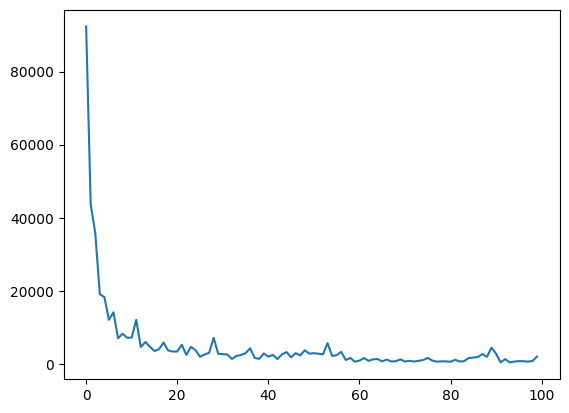

In [ ]:
import matplotlib.pyplot as plt
plt.plot(reward_all)

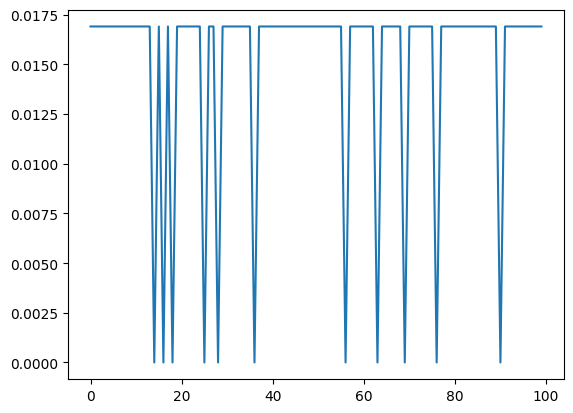

In [ ]:
import matplotlib.pyplot as plt
plt.plot(evaluate_revards)

In [ ]:
from rl_agent import save_dqn_agent

# save_dqn_agent(agent, 'aapl_best_agent_random07_batch8_update5.pth')

In [ ]:
# from multiprocessing import Pool
# from tqdm import tqdm

# def train_wrapper(episode, epsilon):
#     return train_episode(episode, epsilon)

# if __name__ == "__main__":
#     with Pool() as pool:
#         results = list(tqdm(pool.starmap(train_wrapper, [(episode, epsilon) for episode in range(1, EPISODES + 1)]), total=EPISODES, ascii=True, unit='episodes'))

In [ ]:
#from multiprocessing import Pool




#with Pool() as p:
#    print(p.map(train_episode, [episode for episode in range(1, EPISODES + 1)]))

In [ ]:
# def save_dqn_agent(agent, filename="dqn_model.pth"):
#     torch.save({
#         'model_state_dict': agent.model.state_dict(),
#         'target_model_state_dict': agent.target_model.state_dict(),
#         'optimizer_state_dict': agent.optimizer.state_dict(),
#     }, filename)

# save_dqn_agent(agent, "SPY_AGENT.pth")

In [ ]:
ep_rewards

[-200,
 92312.62929999999,
 43614.4767,
 35923.2833,
 19099.77500000003,
 18335.09290000001,
 12111.55570000001,
 14154.700199999997,
 7046.842200000006,
 8277.247799999997,
 7199.063700000004,
 7233.168100000015,
 12077.026799999994,
 4662.156500000008,
 6019.984400000011,
 4747.441599999999,
 3562.7725,
 4067.260400000001,
 5873.666599999998,
 3718.1536000000024,
 3422.4171000000033,
 3433.1838000000002,
 5292.027600000003,
 2498.6398000000036,
 4717.8201000000045,
 3825.836200000002,
 2003.188800000003,
 2593.9085,
 3076.114200000005,
 7155.120200000006,
 2820.692900000001,
 2703.4291000000017,
 2617.650700000006,
 1382.7035999999998,
 2240.6372000000038,
 2454.7410000000004,
 2983.9359000000027,
 4311.141900000008,
 1683.317300000001,
 1416.5847999999999,
 2885.0744999999997,
 2032.6423000000004,
 2508.6927000000037,
 1369.3174999999994,
 2648.7443000000035,
 3267.069200000006,
 1865.4482000000023,
 2977.3127999999992,
 2381.7151999999996,
 3759.681200000001,
 2849.021400000001,
 2

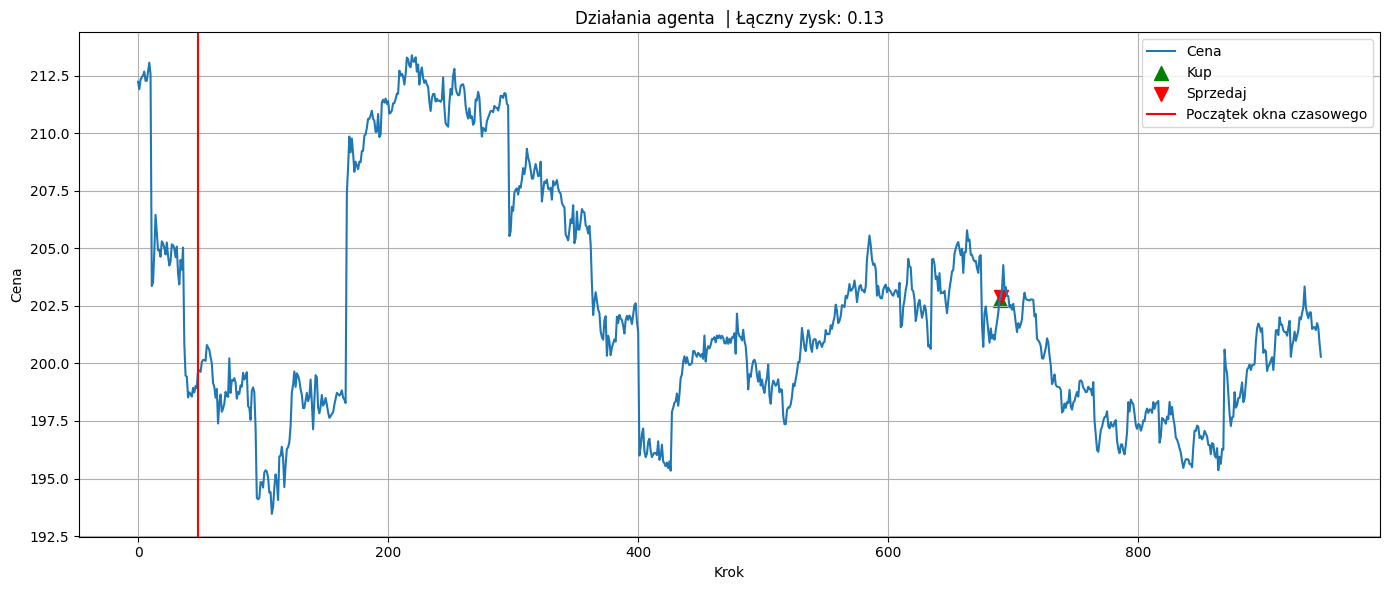

In [ ]:
import torch
import matplotlib.pyplot as plt


def evaluate_steps(env, model, device="cuda:0"):
    state = env.reset()
    total_reward = 0
    done = False
    steps = 0
    action = 0
    while not done:
        # konwersja stanu na tensora
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

        with torch.no_grad():
            q_values = model(state_tensor)
            action = torch.argmax(q_values).item()

        state, reward, done = env.step(action)
        total_reward += reward
        steps += 1
        #print(f"Krok: {steps}, Akcja: {action}, Nagroda: {reward:.2f}, Łączny zysk: {env.total_profit:.2f}")

    #print(state_tensor)
    return total_reward


def render_env(env, title_suffix="", window_size = 48):
    prices = env.data
    buy_points = env.states_buy
    sell_points = env.states_sell
    profit = env.total_profit

    plt.figure(figsize=(14, 6))
    plt.plot(prices, label='Cena', linewidth=1.5)

    if buy_points:
        plt.scatter(buy_points, [prices[i] for i in buy_points],
                    color='green', marker='^', label='Kup', s=100)
    if sell_points:
        plt.scatter(sell_points, [prices[i] for i in sell_points],
                    color='red', marker='v', label='Sprzedaj', s=100)

    plt.title(f'Działania agenta {title_suffix} | Łączny zysk: {profit:.2f}')
    plt.axvline(x = window_size, color = 'red', label = 'Początek okna czasowego')
    plt.xlabel('Krok')
    plt.ylabel('Cena')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

##8847 - duża sieć
##89996
# AAPL 848
# AAPL 357 DUŻA SIEĆ
# AAPL 938 96 LSTM, 8 fc
env.reset()
evaluate_steps(valid_env, max_agent.target_model)
render_env(valid_env, title_suffix="")

In [ ]:
from source.IB_connector import retrive_market_data
ticker = 'AAPL'
training_set_aapl = retrive_market_data([ticker], duration = "1 m", time_interval = "15 mins")
training_set = training_set_aapl[ticker]
training_set['Volume'] = training_set['Volume'].astype(float)
training_set['Date'] = pd.to_datetime(training_set['Date'].str.replace(' US/Eastern',''),format="%Y%m%d %H:%M:%S")
col_select = ['Open','High','Low','Close','Volume']
training_set = training_set[col_select]
training_set.dtypes
CLOSE_INDEX = col_select.index('Close')

ERROR -1 2104 Market data farm connection is OK:usfarm.nj
ERROR -1 2104 Market data farm connection is OK:cashfarm
ERROR -1 2104 Market data farm connection is OK:usfarm
ERROR -1 2106 HMDS data farm connection is OK:ushmds
ERROR -1 2158 Sec-def data farm connection is OK:secdefil


Found window with title: DUK343627 Interactive Brokers (Simulated Trading)


c:\Users\proso\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:1410.)
  result = _VF.lstm(


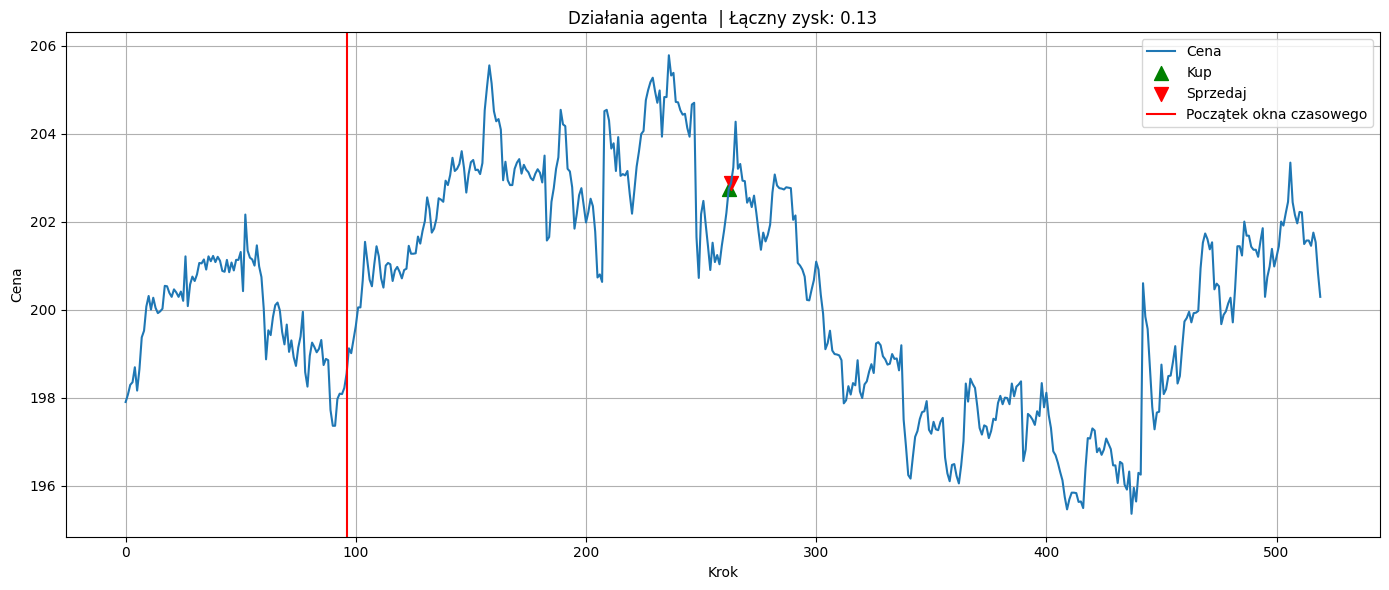

In [ ]:
env = TimeSeriesEnv(data=training_set['Close'].values, window_size=WINDOW_SIZE)

env.reset()
evaluate_steps(env, max_agent.target_model)
render_env(env, title_suffix="", window_size=WINDOW_SIZE)